In [2]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
from src.dataset.dataset import SimpleIterDataset, EventDataset, EventDatasetCollection
from src.utils.utils import to_filelist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', size=13)
from src.plotting.plot_event import plot_event_comparison
from src.dataset.functions_data import concat_events
from src.utils.paths import get_path
from dotenv import load_dotenv
load_dotenv()

True

In [3]:

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
def get_iter(path_to_ds):
    return iter(EventDatasetCollection(path_to_ds, args=None))

inputs = {
    "Delphes": ["Delphes_020425_test_PU_PFfix_part0/SVJ_mZprime-900_mDark-20_rinv-0.3_alpha-peak"],
    "CMS FullSim": ["Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part0/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000",
                    "Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part1/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000",
                    "Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part2/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000",
                    "Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part3/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000",
                    "Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part4/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000"]
}


In [4]:
datasets = {
    key: get_iter([get_path(x, "preprocessed_data") for x in value]) for key, value in inputs.items()
}

Getting query for path Delphes_020425_test_PU_PFfix_part0/SVJ_mZprime-900_mDark-20_rinv-0.3_alpha-peak  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
get_pfcands_key
Getting query for path Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part0/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
Getting query for path Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part1/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
Getting query for path Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part2/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
Getting query for path Feb26_2025_E1000_N500_noPartonFilter_GluonFix_FullF_part3/PFNano_s-channel_mMed-900_mDark-20_rinv-0.3_alpha

In [8]:
e.final_parton_level_particles.pid

NameError: name 'e' is not defined

In [4]:
e = next(datasets["Delphes"])

In [5]:
pid_masses = {}
for i in range(100):
    e = next(datasets["CMS FullSim"])
    for i in range(len(e.pfcands)):
        pid = e.pfcands.pid[i].item()
        if pid not in pid_masses:
            pid_masses[pid] = []
        pid_masses[pid].append(e.pfcands.mass[i].item())

In [ ]:
e = next(datasets["CMS FullSim"])

In [ ]:
pid_masses[211]

In [5]:
from tqdm import tqdm
ch_pids = torch.tensor([211, -211])
nh_pids = torch.tensor([130, 2112])
def get_stats(ds):
    LE_pfcands_PID= []
    result = {
        "n_pfcands": [],
        "pfcands_pt": [],
        "pfcands_eta": [],
        "pfcands_phi": [],
        "pfcands_pid": [],
        "pfcands_mass": [],
        "n_genp": [],
        "n_parton_level": [],
        "genp_pt": [],
        "parton_level_pt": [],
        "pt_ch": [], # low-pt CH
        "pt_nh": [], # low-pt NH
        "pt_gamma": [],
        "E_vis": []
       # "n_dq": []
    }
    for _ in tqdm(range(1500)):
        event = next(ds)
        result["n_pfcands"].append(len(event.pfcands))
        result["pfcands_pt"] += torch.log10(event.pfcands.pt).tolist()
        result["pfcands_eta"] += event.pfcands.eta.tolist()
        result["pfcands_phi"] += event.pfcands.phi.tolist()
        result["pfcands_pid"] += event.pfcands.pid.tolist()
        result["pfcands_mass"] += event.pfcands.mass.tolist()
        result["n_genp"].append(len(event.final_gen_particles))
        result["n_parton_level"].append(len(event.final_parton_level_particles))
        result["genp_pt"] += torch.log10(event.final_gen_particles.pt).tolist()
        result["parton_level_pt"] += torch.log10(event.final_parton_level_particles.pt).tolist()
#        result["pt_ch"] += event.pfcands.pt[event.pfcands.pid.isin(ch_pids)].tolist()
        #result["n_dq"].append(len(event.matrix_element_gen_particles))
        result["pt_ch"] += torch.log10(event.pfcands.pt[torch.isin(event.pfcands.pid, ch_pids)]).tolist()
        result["pt_nh"] += torch.log10(event.pfcands.pt[torch.isin(event.pfcands.pid, nh_pids)]).tolist()
        result["pt_gamma"] += torch.log10(event.pfcands.pt[event.pfcands.pid == 22]).tolist()
        result["E_vis"].append(torch.sum(event.pfcands.E).item())
    return result, LE_pfcands_PID

In [6]:
results = {
    key: get_stats(value)[0] for key, value in datasets.items()
}

#results_PID = {
#    key: get_stats(value)[1] for key, value in datasets.items()
#}

100%|██████████| 1500/1500 [00:05<00:00, 260.39it/s]


In [35]:
import pandas as pd
for key in results:
    print("#######", key, "#######")
    pids = results[key]["pfcands_pid"]
    print(pd.Series(pids).value_counts(normalize=True))
    print("dq", pd.Series(results[key]["n_dq"]).value_counts())

####### Delphes #######
211.0     0.591530
22.0      0.257798
2112.0    0.150672
Name: proportion, dtype: float64


KeyError: 'n_dq'

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


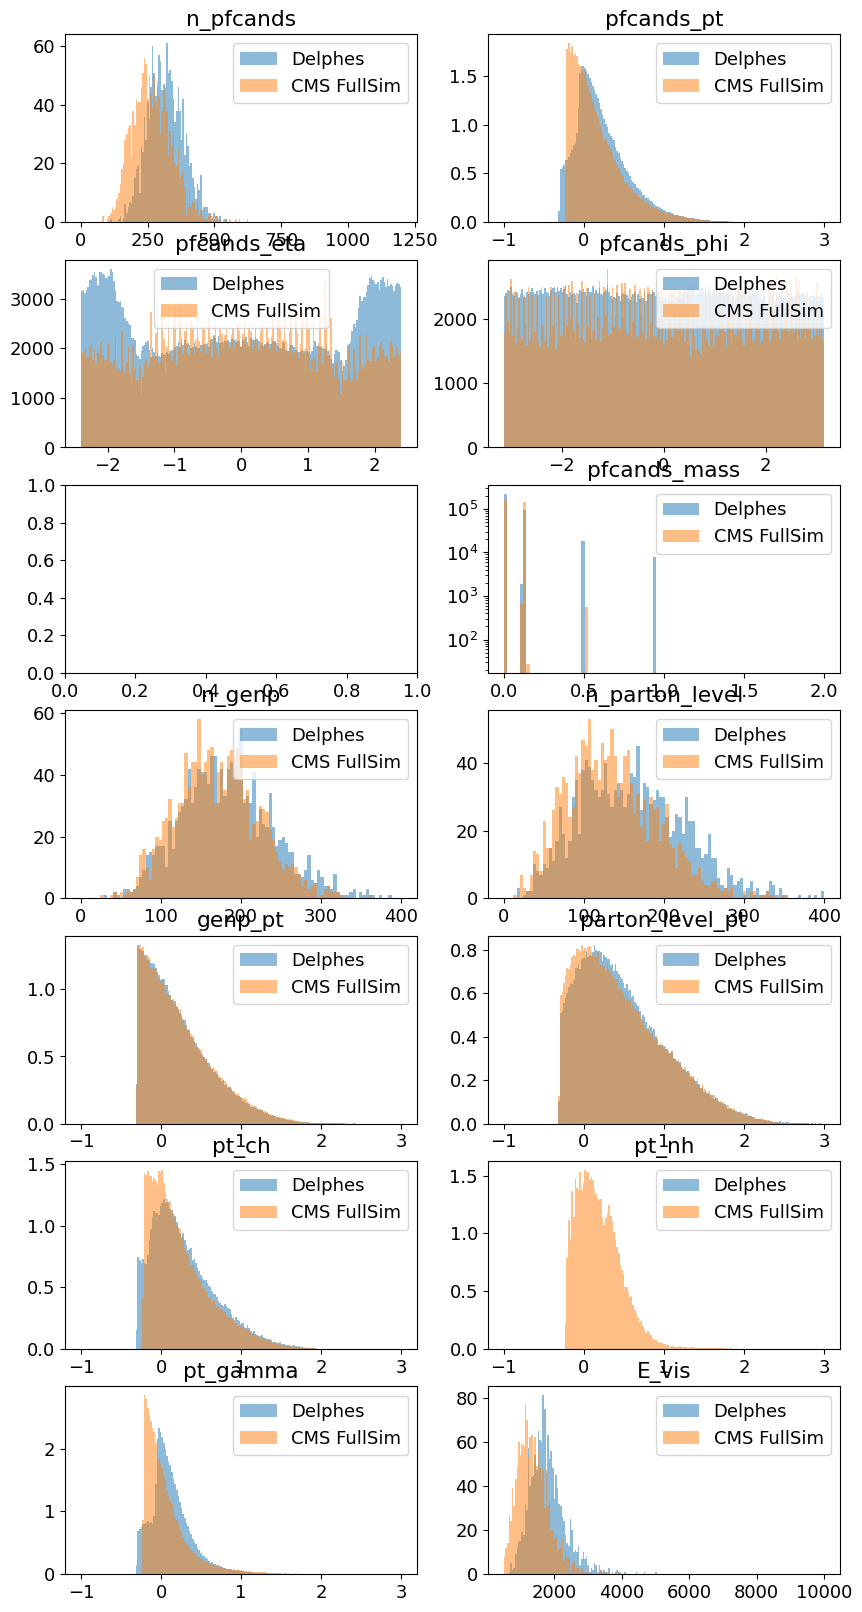

In [7]:
bins = {
    "n_pfcands": np.linspace(0, 1200, 200),
    "pfcands_pt": np.linspace(-1, 3, 200),
    "pfcands_eta": np.linspace(-2.4, 2.4, 200),
    "pfcands_phi": np.linspace(-3.14, 3.14, 200),
    "pfcands_mass": np.linspace(0, 2, 100),
    "n_genp": np.linspace(0,400,100),
    "n_parton_level": np.linspace(0,400,100),
    "genp_pt": np.linspace(-1, 3, 200),
    "parton_level_pt": np.linspace(-1, 3, 200),
    "pt_ch": np.linspace(-1, 3, 200),
    "pt_nh": np.linspace(-1, 3, 200),
    "pt_gamma": np.linspace(-1, 3, 200),
    "E_vis": np.linspace(500, 10000, 200)
    #"n_dq": np.linspace(0, 3, 3)
}
fig, ax = plt.subplots(7, 2, figsize=(10, 20))
for key in results:
    for i, (k, v) in enumerate(results[key].items()):
        if k == "pfcands_pid":
            continue
        ax[i // 2, i % 2].hist(v, bins=bins[k], alpha=0.5, label=key, density="pt" in k)
        ax[i // 2, i % 2].set_title(k)
        if k == "pfcands_pt" or "mass" in k:# or "_pt" in k:
            if not k == "pfcands_pt":
                ax[i//2, i%2].set_yscale("log")
            #ax[i//2, i%2].set_xscale("log")
        ax[i // 2, i % 2].legend()

fig.show()


In [17]:
min(results["Delphes"]["pfcands_pt"])

-0.3010289602264827

In [18]:
min(results["CMS FullSim"]["pfcands_pt"])


-0.22177806941733907

In [19]:
min(results["CMS FullSim"]["pfcands_eta"])


-2.3984375

In [20]:
min(results["Delphes"]["pfcands_eta"])


-2.3999974727630615

In [21]:
t = torch.tensor(results["CMS FullSim"]["pfcands_pt"])

In [22]:
t[t<0.222]

tensor([ 0.2212,  0.2194,  0.2191,  ..., -0.2158, -0.2172, -0.2200])

In [23]:
import pandas as pd
for key in results_PID:
    print(key, "number of PFCands in sample:", len(results_PID[key]))
    print(pd.value_counts(pd.Series(results_PID[key]), normalize=False))


Delphes number of PFCands in sample: 426711
211.0     306595
22.0       95529
2112.0     24587
Name: count, dtype: int64
CMS FullSim number of PFCands in sample: 149427
 22.0     75853
 130.0    28642
 211.0    22569
-211.0    22363
Name: count, dtype: int64


/tmp/ipykernel_61141/3118960101.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(pd.Series(results_PID[key]), normalize=False))
